# Evaluate Geolocation Predictions of Osv5M Model
This notebook evaluates the geolocation predictions of the Osv5M model trained on the CrossLocate (Uniform) dataset using geodesic distance and plots a recall curve.

In [9]:
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import matplotlib.ticker as ticker

In [10]:
# Main evaluation function
def evaluate_geolocation(csv_gt, csv_pred):
    df_gt = pd.read_csv(csv_gt)
    df_pred = pd.read_csv(csv_pred)

    # Rename the "image" column in predictions to "image_pred"
    df_pred.rename(columns={"image": "image_pred"}, inplace=True) # remove .jpg, .png, etc.

    # Strip file extension from the predictions
    df_pred['image_clean'] = (
        df_pred['image_pred']
        .str.replace(r'\.[^.]+$', '', regex=True)
        .str.strip()
    )

    # Strip whitespace from gt's "image" column
    df_gt['image'] = df_gt['image'].str.strip()

    # Convert latitude and longitude from radians to degrees
    df_pred['pred_lat_deg'] = df_pred['latitude_radians'] * (180.0 / math.pi)
    df_pred['pred_lon_deg'] = df_pred['longitude_radians'] * (180.0 / math.pi)

    # Merge the dataframes on 'image' (ground truth) and 'image_clean' (predictions)
    df_merged = pd.merge(
        df_gt,
        df_pred,
        left_on='image',        # ground truth
        right_on='image_clean'  # predictions
    )

    # Compute geodesic distance between ground truth and predicted coordinates using geopy's geodesic function.
    # The geodesic function takes coordinates in degrees and returns the distance in meters.
    distances = []
    for idx, row in df_merged.iterrows():
        gt_coords = (row['latitude'], row['longitude'])             # degrees
        pred_coords = (row['pred_lat_deg'], row['pred_lon_deg'])    # degrees
        dist_m = geodesic(gt_coords, pred_coords).meters
        distances.append(dist_m)

    distances = np.array(distances)

    print("\nDistance stats:")
    if len(distances) > 0:
        print(f"  Min: {distances.min():.2f} m")
        print(f"  Max: {distances.max():.2f} m")
        print(f"  Mean: {distances.mean():.2f} m")
        print(f"  Median: {np.median(distances):.2f} m")
    else:
        print("  No distances computed (0 rows).")

    return distances

In [11]:
# Compute recall at multiple distance thresholds.
def plot_recall_curve(distances, output_path="recall_curve.png"):
    if len(distances) == 0:
        print("No distances to plot.")
        return

    thresholds = np.linspace(0, 10000, 101)     # e.g. 0 to 10km in steps of 100
    recalls = [np.mean(distances <= t) for t in thresholds]

    # Plot the recall vs distance curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, recalls, label="Osv5M model", color="magenta", linewidth=2)
    plt.axvline(x=1000, linestyle="dotted", label="1000m distance", color="gray")

    plt.xlabel("Distance [m]")
    plt.ylabel("Recall")
    plt.title("Localization (Uniform dataset)")
    plt.ylim(-0.05, 1)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    current_ticks = plt.gca().get_yticks()
    new_ticks = [t for t in current_ticks if t > -0.01 and t < 1]
    plt.gca().set_yticks(new_ticks)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Distance stats:
  Min: 401.99 m
  Max: 18938061.19 m
  Mean: 644601.77 m
  Median: 121870.45 m


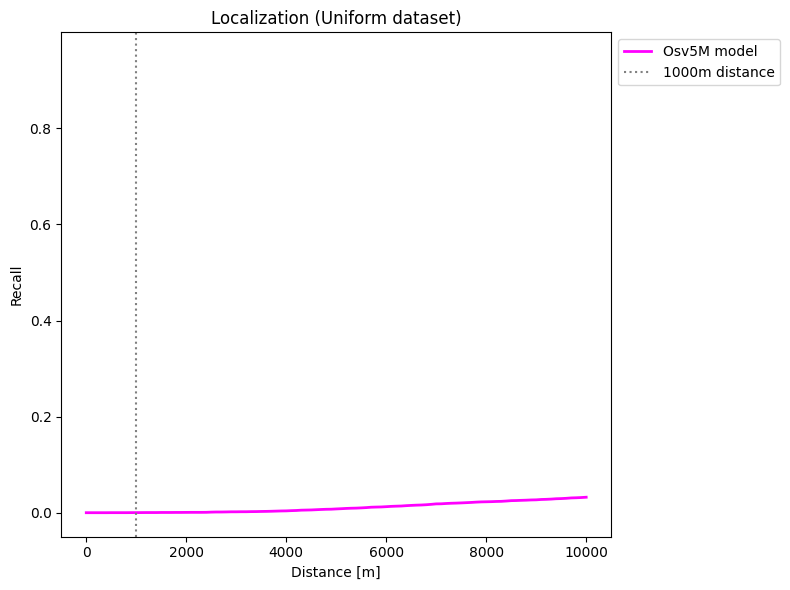

In [12]:
# Example usage (change paths if needed)
csv_gt_path = "../../data/datasetInfoClean.csv"
csv_pred_path = "../../data/geolocations_uniform.csv"

distances = evaluate_geolocation(csv_gt_path, csv_pred_path)
plot_recall_curve(distances)